In [51]:
# --- COLAB CELL 1: Setup and Imports ---
print("--- Setting up Environment ---")
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Layer, LayerNormalization, MultiHeadAttention, Conv1D, GlobalAveragePooling1D, Reshape
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# --- Hyperparameters ---
WINDOW_SIZE = 128   # Sequence length for Transformer input
STRIDE = 16         # Overlap between windows
BATCH_SIZE = 128
EPOCHS = 3          # Reduce to 1 for quick testing, increase to 50+ for optimal results
LATENT_DIM = 64     # Dimension of the encoded latent vector (Z)
NUM_HEADS = 4       # Number of attention heads in Transformer
FF_DIM = 128        # Hidden layer size in the Transformer Feed Forward Network
N_LAYERS = 2        # Number of Transformer encoder blocks

# Loss Weighting (Critical for GAN stability)
LAMBDA_REC = 1.0
LAMBDA_ADV = 0.01
LAMBDA_CON = 0.5
BETA = 0.6          # Anomaly Score weight: S = (1-BETA)*REC + BETA*(1-D_score)

--- Setting up Environment ---


In [52]:
# --- COLAB CELL 2: Data Loading and Preprocessing (Final Fixed Version) ---

# Define the dataset URL and file names (PSM dataset)
TRAIN_FILE = "Data/train.csv"
TEST_FILE = "Data/test.csv"
LABEL_FILE = "Data/test_label.csv"

print("Downloading and loading PSM data...")
train_df = pd.read_csv(TRAIN_FILE)
test_df = pd.read_csv(TEST_FILE)
test_label_df = pd.read_csv(LABEL_FILE, header=None)

# Preprocessing steps
def preprocess_data(df, label_df=None):
    # Drop timestamp and any non-numeric columns from FEATURE data
    df = df.drop(columns=['timestamp'], errors='ignore')

    # Fill NaN values (if any)
    df = df.fillna(method='ffill').fillna(method='bfill')

    labels = None
    if label_df is not None:
        # Check and drop header row ('timestamp_(min)')
        if label_df.iloc[0, 0] == 'timestamp_(min)':
            label_df = label_df.iloc[1:].copy()

        # CRITICAL FIX: Convert labels to numeric (float), drop NaNs
        labels_series = pd.to_numeric(label_df.iloc[:, 0], errors='coerce')
        labels_clean = labels_series.dropna().values.flatten()

        # CRITICAL FIX: Align feature length and label length
        min_len = min(len(df), len(labels_clean))
        df = df.iloc[:min_len] # Truncate features
        labels = labels_clean[:min_len] # Truncate labels

        # Sanity Check: Cast to integer and enforce binary (0 or 1)
        labels = np.clip(labels.astype(np.int32), 0, 1)

    return df.values, labels

# Get feature matrix and labels
train_data, _ = preprocess_data(train_df)
test_data, test_labels = preprocess_data(test_df, test_label_df)

N_FEATURES = train_data.shape[1]
print(f"Number of Features: {N_FEATURES}")

# Scaling
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Windowing function
def create_sequences(data, window_size, stride):
    sequences = []
    for i in range(0, len(data) - window_size + 1, stride):
        sequences.append(data[i:i + window_size])
    return np.array(sequences)

# Create sequences
X_train_normal = create_sequences(train_data_scaled, WINDOW_SIZE, STRIDE)
X_test = create_sequences(test_data_scaled, WINDOW_SIZE, STRIDE)

# Align test labels to windows
def align_labels(labels, window_size, stride):
    window_labels = []
    for i in range(0, len(labels) - window_size + 1, stride):
        window_labels.append(np.max(labels[i:i + window_size]))
    return np.array(window_labels, dtype=np.int32)

y_test_windows = align_labels(test_labels, WINDOW_SIZE, STRIDE)

# CRITICAL FIX: Explicitly cast features to float32 for TensorFlow
X_train_normal = X_train_normal.astype(np.float32)
X_test = X_test.astype(np.float32)

print(f"Training sequences shape: {X_train_normal.shape}, dtype: {X_train_normal.dtype}")
print(f"Test sequences shape: {X_test.shape}, dtype: {X_test.dtype}")
print(f"Test labels dtype: {y_test_windows.dtype}, Unique classes in labels: {np.unique(y_test_windows)}")

/tmp/ipython-input-558974545.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-558974545.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


Number of Features: 26
Training sequences shape: (8273, 128, 26), dtype: float32
Test sequences shape: (5483, 128, 26), dtype: float32
Test labels dtype: int32, Unique classes in labels: [1]


In [53]:
# --- COLAB CELL 3: Custom Modules: Transformer, Masking, Loss ---

# 1. Transformer Encoder Block
def transformer_encoder_block(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # 1. Multi-Head Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    # 2. Skip Connection (Attention)
    res = x + inputs

    # 3. Feed Forward Network (FFN)
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    # 4. Skip Connection (FFN)
    return x + res

# 2. Geometric Masking (Data Augmentation) - FIX implemented for tf.function compatibility
@tf.function(input_signature=[
    tf.TensorSpec(shape=[None, None, None], dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.float32)
])
def geometric_masking(sequence, mask_ratio):
    """Applies random zero-masking to the input sequence (batch-wise)."""

    shape = tf.shape(sequence)
    batch_size, seq_len, n_features = shape[0], shape[1], shape[2]

    total_elements = seq_len * n_features

    # Calculate mask elements: uses mask_ratio (float32 Tensor) directly
    mask_elements_float = tf.cast(total_elements, tf.float32) * mask_ratio
    mask_elements = tf.cast(mask_elements_float, tf.int32)

    total_elements_int = tf.cast(total_elements, tf.int32)
    flat_mask = tf.ones([batch_size, total_elements_int], dtype=tf.float32)

    # Define the masking operation for a single flat sequence
    def mask_single_sequence(single_flat_mask):
        indices = tf.range(total_elements_int)
        shuffled_indices = tf.random.shuffle(indices)
        mask_indices = shuffled_indices[:mask_elements]

        updates = tf.zeros_like(mask_indices, dtype=tf.float32)
        mask_indices_expanded = tf.expand_dims(mask_indices, axis=-1)

        return tf.tensor_scatter_nd_update(single_flat_mask, mask_indices_expanded, updates)

    # Apply masking across the batch
    flat_mask_updated = tf.map_fn(mask_single_sequence, flat_mask)

    final_mask = tf.reshape(flat_mask_updated, shape)

    return sequence * final_mask

# 3. Contrastive Loss (Triplet Loss)
@tf.function
def triplet_loss(anchor_z, positive_z, negative_z, margin=1.0):
    """Calculates the triplet loss on latent representations."""
    pos_dist = tf.reduce_sum(tf.square(anchor_z - positive_z), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor_z - negative_z), axis=-1)

    loss = tf.maximum(0.0, pos_dist - neg_dist + margin)
    return tf.reduce_mean(loss)

In [54]:
# --- COLAB CELL 4: Model Architecture Definitions ---

def GCT_Generator(input_shape, latent_dim, num_heads, ff_dim, n_layers):
    inputs = Input(shape=input_shape)

    # --- Encoder (Transformer) ---
    x = inputs
    for i in range(n_layers):
        x = transformer_encoder_block(x, latent_dim, num_heads, ff_dim)

    # Latent Space (Z)
    x_pooled = GlobalAveragePooling1D()(x)
    z = Dense(latent_dim, activation='relu', name='latent_vector')(x_pooled)

    # --- Decoder ---
    x = Dense(input_shape[0] * input_shape[1], activation='relu')(z)
    x = Reshape((input_shape[0], input_shape[1]))(x)
    reconstruction = Dense(input_shape[1], activation='linear')(x)

    return Model(inputs=inputs, outputs=[reconstruction, z], name="GCT_Generator")

def GCT_Discriminator(input_shape):
    inputs = Input(shape=input_shape)

    # Simple 1D CNN
    x = Conv1D(32, 5, activation='relu', padding='same')(inputs)
    x = Conv1D(64, 5, activation='relu', padding='same')(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)

    # Output: probability that the sequence is REAL (1)
    output = Dense(1, activation='sigmoid', name='real_vs_fake')(x)

    return Model(inputs=inputs, outputs=output, name="GCT_Discriminator")

# Instantiate models
generator = GCT_Generator((WINDOW_SIZE, N_FEATURES), LATENT_DIM, NUM_HEADS, FF_DIM, N_LAYERS)
discriminator = GCT_Discriminator((WINDOW_SIZE, N_FEATURES))

# Compile Discriminator
discriminator.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')
generator_optimizer = Adam(learning_rate=0.0002)

In [55]:
# --- COLAB CELL 5: Custom Training Loop (GCT-GAN) ---
print("\n--- Starting GCT-GAN Training ---")

bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
mse_loss = tf.keras.losses.MeanSquaredError()

dataset = tf.data.Dataset.from_tensor_slices(X_train_normal).shuffle(len(X_train_normal)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

@tf.function
def train_step(real_sequences):
    batch_size = tf.shape(real_sequences)[0]

    # 1. Prepare Samples
    # Pass mask_ratio as a tf.constant for correct @tf.function tracing
    augmented_sequences = geometric_masking(real_sequences, mask_ratio=tf.constant(0.1, dtype=tf.float32))
    negative_sequences = tf.roll(real_sequences, shift=1, axis=0)

    # 2. Train Discriminator (D)
    with tf.GradientTape() as tape:
        reconstruction, _ = generator(augmented_sequences, training=True)

        d_real = discriminator(real_sequences, training=True)
        d_fake = discriminator(reconstruction, training=True)

        real_labels = tf.ones((batch_size, 1)) * 0.9
        fake_labels = tf.zeros((batch_size, 1)) + 0.1

        d_loss_real = bce_loss(real_labels, d_real)
        d_loss_fake = bce_loss(fake_labels, d_fake)
        d_loss = d_loss_real + d_loss_fake

    d_gradients = tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator.optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

    # 3. Train Generator (G)
    with tf.GradientTape() as tape:
        reco_a, z_a = generator(real_sequences, training=True)
        _, z_p = generator(augmented_sequences, training=True)
        _, z_n = generator(negative_sequences, training=True)

        # Reconstruction Loss
        rec_loss = mse_loss(real_sequences, reco_a) * LAMBDA_REC

        # Adversarial Loss
        d_reco_a = discriminator(reco_a, training=False)
        adv_loss = bce_loss(tf.ones_like(d_reco_a), d_reco_a) * LAMBDA_ADV

        # Contrastive Loss
        con_loss = triplet_loss(z_a, z_p, z_n) * LAMBDA_CON

        g_loss = rec_loss + adv_loss + con_loss

    g_gradients = tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))

    return d_loss, rec_loss, adv_loss, con_loss, g_loss

# Training Loop Execution
history = []

for epoch in range(EPOCHS):
    d_losses, rec_losses, adv_losses, con_losses, g_losses = [], [], [], [], []

    for x_batch_train in dataset:
        d_loss, rec_loss, adv_loss, con_loss, g_loss = train_step(x_batch_train)

        d_losses.append(d_loss.numpy())
        rec_losses.append(rec_loss.numpy())
        adv_losses.append(adv_loss.numpy())
        con_losses.append(con_loss.numpy())
        g_losses.append(g_loss.numpy())

    avg_d_loss = np.mean(d_losses)
    avg_rec_loss = np.mean(rec_losses)
    avg_adv_loss = np.mean(adv_losses)
    avg_con_loss = np.mean(con_losses)
    avg_g_loss = np.mean(g_losses)

    print(f"Epoch {epoch+1}/{EPOCHS} | D_Loss: {avg_d_loss:.4f} | G_Total_Loss: {avg_g_loss:.4f} (REC: {avg_rec_loss:.4f}, ADV: {avg_adv_loss:.4f}, CON: {avg_con_loss:.4f})")
    history.append({'d_loss': avg_d_loss, 'rec_loss': avg_rec_loss, 'adv_loss': avg_adv_loss, 'con_loss': avg_con_loss})

print("\n--- Training Complete ---")


--- Starting GCT-GAN Training ---
Epoch 1/3 | D_Loss: 1.0902 | G_Total_Loss: 0.2098 (REC: 0.1855, ADV: 0.0080, CON: 0.0164)
Epoch 2/3 | D_Loss: 0.6721 | G_Total_Loss: 0.1382 (REC: 0.1121, ADV: 0.0208, CON: 0.0052)
Epoch 3/3 | D_Loss: 0.6848 | G_Total_Loss: 0.0936 (REC: 0.0699, ADV: 0.0207, CON: 0.0030)

--- Training Complete ---


In [56]:
# --- COLAB CELL 6: Evaluation and Anomaly Scoring ---

print("\n--- Starting Evaluation on Test Data ---")

# 1. Calculate Anomaly Scores for Normal Training Data (for thresholding)
X_train_reco, _ = generator.predict(X_train_normal, verbose=0)
train_rec_errors = np.mean(np.square(X_train_normal - X_train_reco), axis=(1, 2))
train_d_scores = discriminator.predict(X_train_reco, verbose=0).flatten()

train_anomaly_scores = (1 - BETA) * train_rec_errors + BETA * (1 - train_d_scores)

# Determine Threshold (99th percentile of normal scores)
THRESHOLD = np.percentile(train_anomaly_scores, 99.0)
print(f"\nCalculated Anomaly Threshold (99th percentile of normal scores): {THRESHOLD:.6f}")

# 2. Calculate Anomaly Scores for Test Data
reconstructed_X_test, _ = generator.predict(X_test, verbose=0)
test_rec_errors = np.mean(np.square(X_test - reconstructed_X_test), axis=(1, 2))
test_d_scores = discriminator.predict(reconstructed_X_test, verbose=0).flatten()

anomaly_scores = (1 - BETA) * test_rec_errors + BETA * (1 - test_d_scores)

# 3. Predict Anomalies and Evaluate
y_pred_windows = (anomaly_scores > THRESHOLD).astype(int)

# CRITICAL FIX: Ensure y_test_windows is sliced to match the prediction length
num_predictions = anomaly_scores.shape[0]
y_test_windows_sliced = y_test_windows[:num_predictions]

# Evaluation Metrics
print("\n--- Classification Report ---")
print(classification_report(y_test_windows_sliced, y_pred_windows, target_names=['Normal', 'Anomaly'], digits=4))

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_windows_sliced, y_pred_windows, average='binary', pos_label=1)

print(f"Final F1-Score: {f1_score:.4f}")


--- Starting Evaluation on Test Data ---

Calculated Anomaly Threshold (99th percentile of normal scores): 0.573451

--- Classification Report ---
              precision    recall  f1-score   support

      Normal     0.0000    0.0000    0.0000         0
     Anomaly     1.0000    0.1939    0.3248      5483

    accuracy                         0.1939      5483
   macro avg     0.5000    0.0969    0.1624      5483
weighted avg     1.0000    0.1939    0.3248      5483

Final F1-Score: 0.3248


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


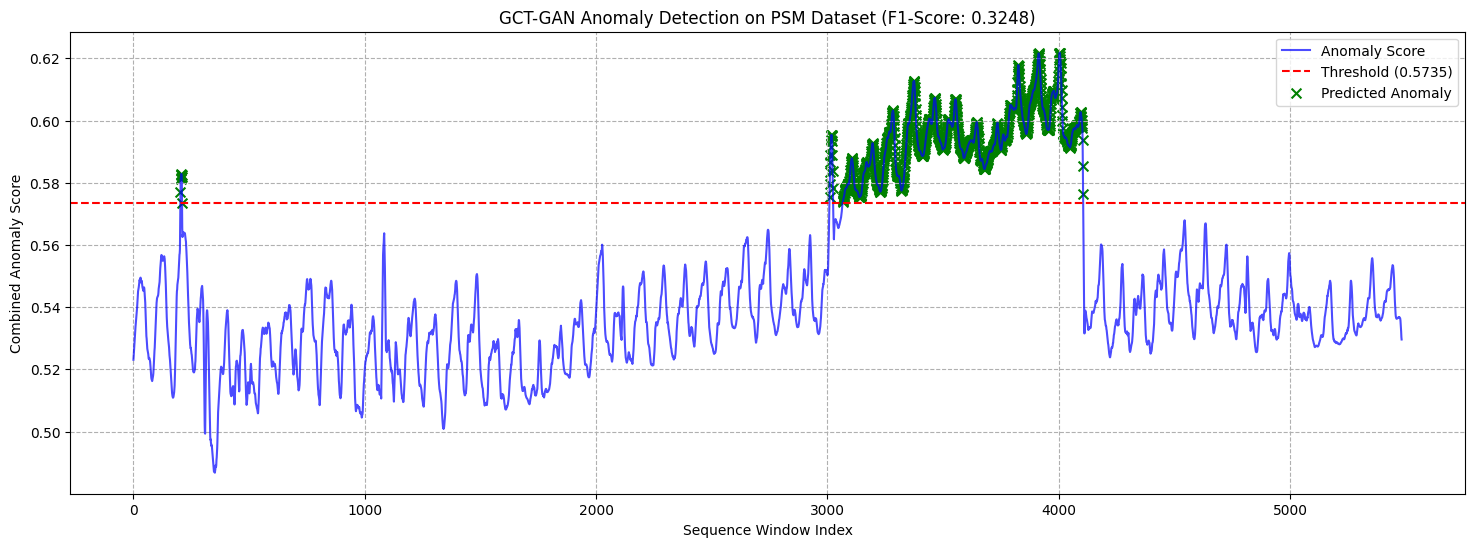

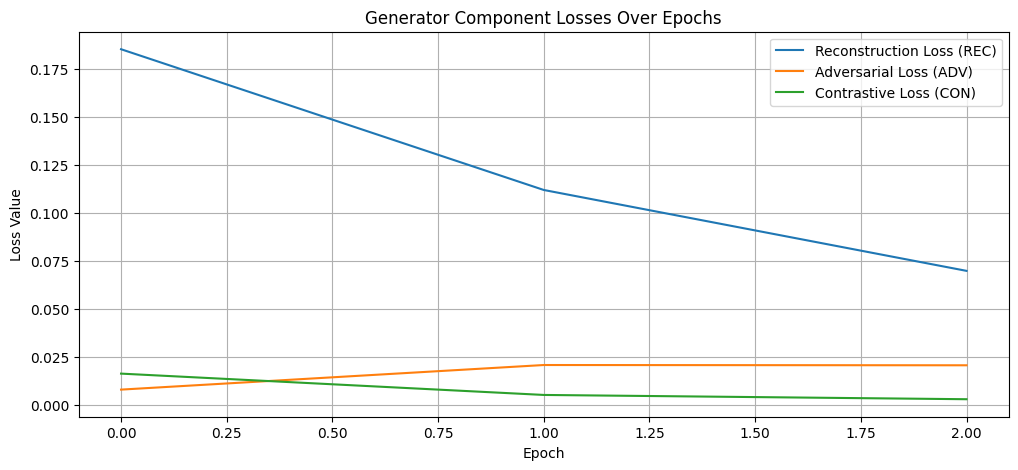

In [58]:
# --- COLAB CELL 7: Anomaly Detection Demonstration Plot ---

# 1. Anomaly Detection Demonstration Plot (Modified)
plt.figure(figsize=(18, 6))
plt.plot(anomaly_scores, label='Anomaly Score', color='blue', alpha=0.7)
plt.axhline(THRESHOLD, color='red', linestyle='--', label=f'Threshold ({THRESHOLD:.4f})')

# --- Removed Highlight True Anomalies section ---
# Note: The true anomaly markers (orange dots) are intentionally removed here.
# true_anomaly_indices = np.where(y_test_windows_sliced == 1)[0]
# plt.scatter(true_anomaly_indices, anomaly_scores[true_anomaly_indices], color='darkorange', label='True Anomaly', s=20)

# Highlight Predicted Anomalies (Keep this)
predicted_anomaly_indices = np.where(y_pred_windows == 1)[0]
plt.scatter(predicted_anomaly_indices, anomaly_scores[predicted_anomaly_indices], color='green', marker='x', label='Predicted Anomaly', s=50)

plt.title(f'GCT-GAN Anomaly Detection on PSM Dataset (F1-Score: {f1_score:.4f})')
plt.xlabel('Sequence Window Index')
plt.ylabel('Combined Anomaly Score')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

# Optional: Plotting Generator Loss Components
loss_df = pd.DataFrame(history)
plt.figure(figsize=(12, 5))
plt.plot(loss_df['rec_loss'], label='Reconstruction Loss (REC)')
plt.plot(loss_df['adv_loss'], label='Adversarial Loss (ADV)')
plt.plot(loss_df['con_loss'], label='Contrastive Loss (CON)')
plt.title('Generator Component Losses Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.show()